# k-evolution test notebook - implementing IC from class

In [45]:
import numpy as np
# import MAS_library as MASL
# import plotting_library as PL
from pylab import *
from matplotlib.colors import LogNorm
import matplotlib as plt
import pandas as pd
# import h5py as h5
import matplotlib.pyplot as plt
text_size=26
fig_size_x=24
fig_size_y=14
from collections import defaultdict

import seaborn as sns
Colors = sns.color_palette("colorblind", 30).as_hex()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
import scipy.signal as sig
# from scipy.ndimage import gaussian_filter1

In [2]:
from collections import defaultdict
a = defaultdict(list)

In [4]:
a[1]="ahmad"
a[2]=[1,2,3,4]
a[3]= [[1,1,1]]

In [6]:
a[1][2]=1

TypeError: 'str' object does not support item assignment

# Nested dictionary

In [7]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data = nested_dict(5, list)
data_test = nested_dict(5, list)


def correct_label(name):
    return(name.replace("_",", "))
        

In [12]:
a = nested_dict(3,list)
a["file1"]["pk"]["z"] = 1
# a[3][4] = [1,1,2]

In [11]:
a

defaultdict(<function __main__.nested_dict.<locals>.<lambda>()>,
            {1: defaultdict(<function __main__.nested_dict.<locals>.<lambda>()>,
                         {2: 'ahmad'}),
             3: defaultdict(<function __main__.nested_dict.<locals>.<lambda>()>,
                         {4: [1, 1, 2]})})

## Background

In [47]:
As=2.215*1.e-9;
h=0.67556;
kp=0.05/h; 
ns=0.9619;
cs2_e3=1.e-7;
c=2.99792458*1.e5; #Km/s
Boxsize=320.;
c_gev=2997.92458; #[100km/s]
H0_conf_Gev=np.sqrt(Boxsize**2/c**2); #0.10677 rho_crit in Gev=1
H0=100*h/c; #H0 in 1/Mpc unit. 0.00022593979933110373
# print("H0[1/Mpc]=100h/c: ",H0);
w=-0.9;
# print("H0[1/Mpc]=100h/c: ",H0);
def Hubble_conf_Mpc(a):
    c=2.99792458*1.e5;h=0.67556;H0=100*h/c;w=-0.9;
    Omega_b=0.022032/h/h; Omega_cdm=0.12038/h/h;
    Omega_m=Omega_b+Omega_cdm; Omega_Lambda=0;
    Omega_rad=9.1671353942930788e-05; Omega_kessence=1.-Omega_m-Omega_rad;
    return H0*np.sqrt(Omega_m*(a**-3)+Omega_rad*(a**-4)+Omega_kessence*(a**(-3*(1+w))))*a

In [48]:
redshifts = [100, 50, 30,20, 10, 9, 8, 7, 6 , 5, 4, 3, 2.5, 2, 1.5, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0]
address_test = "./../../k-evolution_devel-test/output"
address = "./..//output"

for speed in ['cs2em4', 'cs2em7']:
    for types in ['kev_hiclass','kev_class','kev_file']:
        for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
            if (types=='kev_hiclass'):
                data[types][speed]['bg'] =np.loadtxt(address+"/file_background.dat")
                data_test[types][speed]['bg'] =np.loadtxt(address_test+"/file_background.dat")
            else:
                data[types][speed]['bg'] = np.loadtxt("./"+types+"_"+speed+"/file_background.dat")

            for i in range(np.shape(redshifts)[0]):
                if (types=='kev_hiclass'):
                    z = str(redshifts[i])
                    data[types][speed][kind][z] = np.loadtxt(address+"/pk_"+str(i).zfill(3)+"_"+kind+".dat")
                    data_test[types][speed][kind][z] = np.loadtxt(address_test+"/pk_"+str(i).zfill(3)+"_"+kind+".dat")
                else:
                    z = str(redshifts[i])
                    data[types][speed][kind][z] = np.loadtxt("./"+types+"_"+speed+"/pk_"+str(i).zfill(3)+"_"+kind+".dat")

                
for speed in ['cs2em4', 'cs2em7']:
    data['class'][speed]['bg'] =np.loadtxt('./class_'+speed+"/file_classbackground.dat")
    for types in ['tk']:
            for i in range(np.shape(redshifts)[0]):
                z = str(redshifts[i])
                data['class'][types][speed][z] = np.loadtxt('./class_'+speed+"/file_classz"+str(i+1)+"_tk.dat")


# Background test

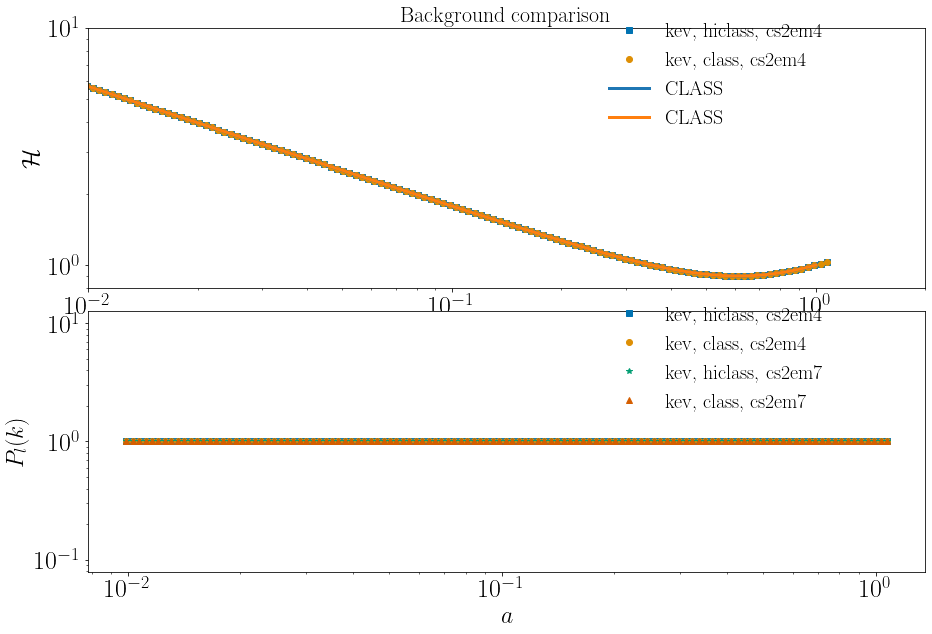

In [35]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,10),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)
l=0

###
speed='cs2em4';
types = 'kev_class'
lines=["s","o","*"]
l=0
# for types in ['kev_hiclass','kev_class', 'kev_file']:
for types in ['kev_hiclass','kev_class']:

    file = data[types][speed]['bg']
    f = interpolate.interp1d(file[:,2],file[:,3])
    axs[0].loglog(file[:,2],file[:,3],lines[l],color =Colors[l], lw=3,label=correct_label(types +", "+speed))
    l=l+1
for speed in ['cs2em4', 'cs2em7']:
    file_class = data['class'][speed]['bg']
    z = file_class[:,0]
    a = 1./(1. + z )
    f_class = interpolate.interp1d(a, file_class[:,3])

    axs[0].loglog(a,file_class[:,3]*a*f(1)/f_class(1), lw=3,label="CLASS")

axs[0].set_ylabel(r'$\mathcal{H}$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(0.8,1.e1)
axs[0].set_xlim(1.e-2,2.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


l=0
lines=["s","o","*","^"]
for speed in ['cs2em4', 'cs2em7']:
#     for types in ['kev_class', 'kev_file']:
    for types in ['kev_hiclass','kev_class']:

        file_based = data['kev_class']['cs2em7']['bg']
        file = data[types][speed]['bg']

        axs[1].loglog(file[:,2],file[:,3]/file_based[:,3],lines[l],color =Colors[l], lw=3,label=correct_label(types +", "+speed))
        l=l+1


axs[1].set_ylabel(r'$P_{l}(k)$',fontsize=24)
axs[1].set_xlabel('$a$',fontsize=24)
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].set_ylim(-0.01,0.01)
# axs[1].set_xlim(1.e-2,2.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


# Matter power spectrum CHECK

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.


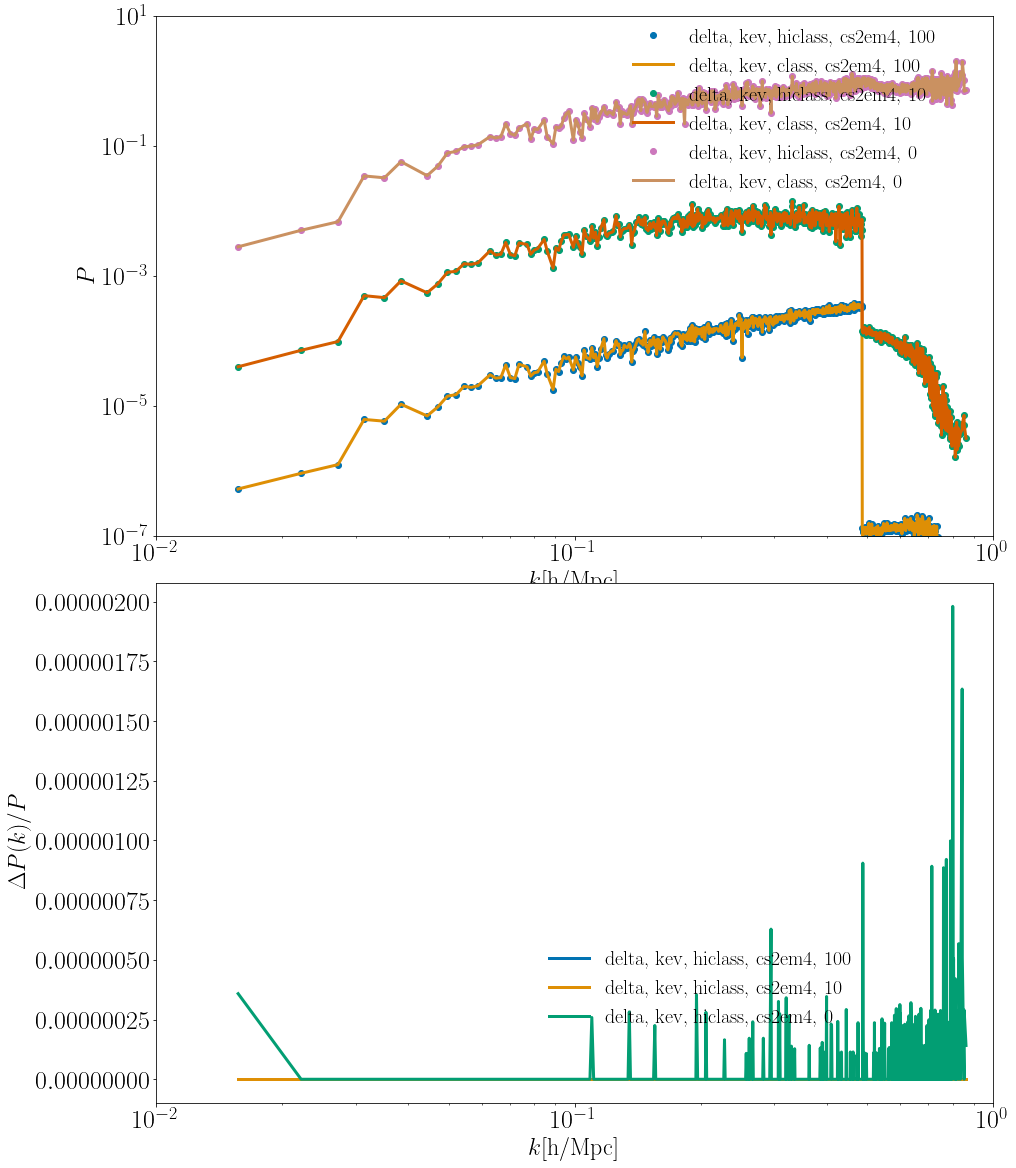

In [36]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)

Normlization=As*(data['class']['tk']['cs2em4']['100'][:,0]/kp)**(ns-1.);

lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0"]:
    l=0
    for speed in ['cs2em4']:
        for kind in ['delta']:
#             lc=0

#             for types in ['kev_hiclass','kev_class','kev_file']:
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
            for types in ['kev_hiclass','kev_class']:

                file = data[types][speed][kind][z]
                axs[0].loglog(file[:,0],file[:,1],lines[l],color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

# for z in ["100","1","0"]:
#     for speed in ['cs2em4']:        
#         for types in ['tk']:
#             file = data['class'][types][speed][z];
#             k = file[:,0]
#             delta_cdm = file[:,3]
#             power = delta_cdm**2 * (Normlization)
#             axs[0].loglog(k, power,"-",color =Colors[l+1], lw=3,label=correct_label("class"+types+", "+speed+", "+z))
#             l=l+1

axs[0].set_ylabel(r'$P$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-7,1.e1)
axs[0].set_xlim(1.e-1,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0"]:
    for speed in ['cs2em4']:
        for kind in ['delta']:
#             lc=0
            for types in ['kev_hiclass']:
                file_base=data['kev_class'][speed][kind][z]
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[1].plot(file[:,0],np.abs(file[:,1]/file_base[:,1]-1),"-",color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

axs[1].set_ylabel(r'$\Delta P(k)/P$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].set_ylim(1.e-16,10)
axs[1].set_xlim(1.e-2,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.65,0.22],loc="center",frameon=False)


# Potential power spectrum

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.


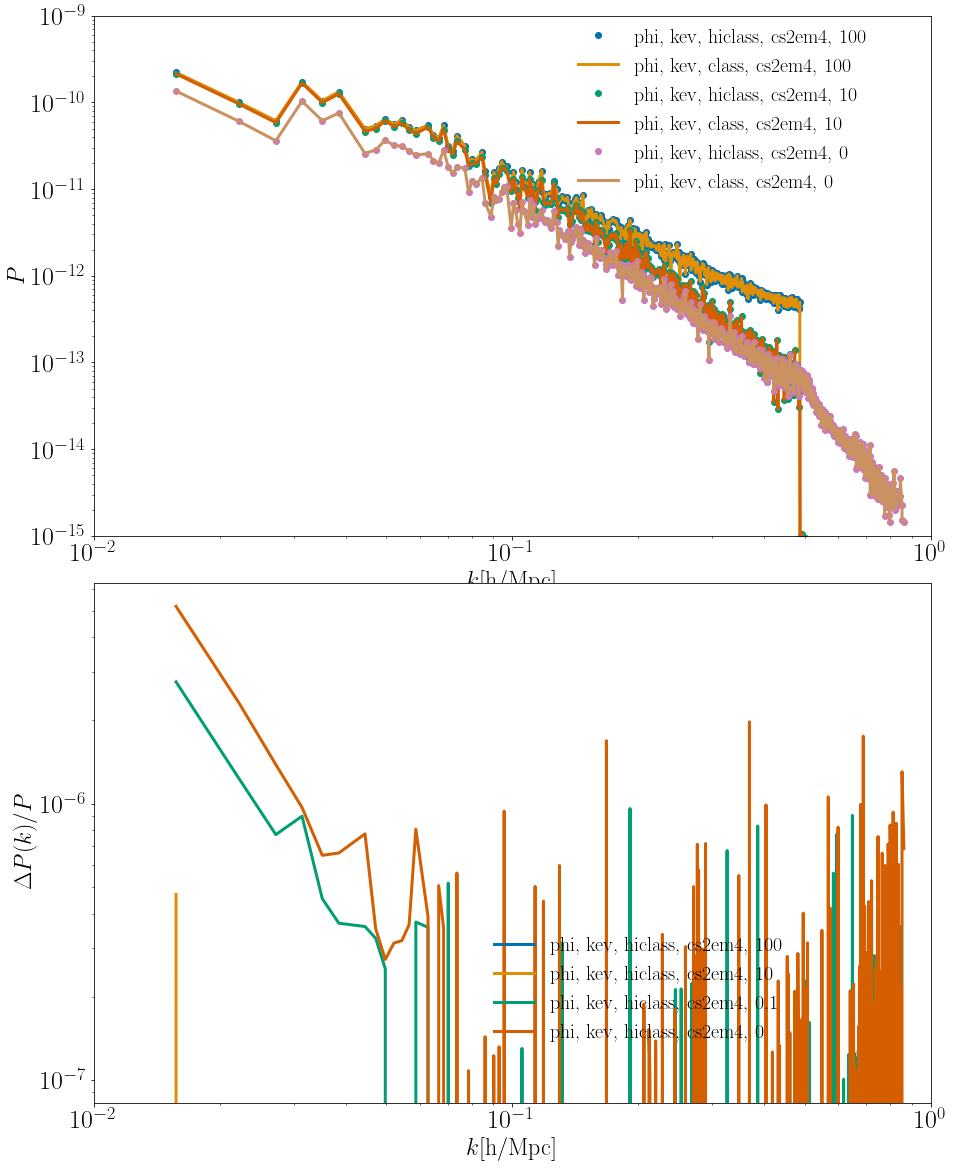

In [37]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)

Normlization=As*(data['class']['tk']['cs2em4']['100'][:,0]/kp)**(ns-1.);

lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0"]:
    l=0
    for speed in ['cs2em4']:
        for kind in ['phi']:
#             lc=0
            for types in ['kev_hiclass','kev_class']:
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[0].loglog(file[:,0],file[:,1],lines[l],color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

# for z in ["100","1","0"]:
#     for speed in ['cs2em4']:        
#         for types in ['tk']:
#             file = data['class'][types][speed][z];
#             k = file[:,0]
#             delta_cdm = file[:,3]
#             power = delta_cdm**2 * (Normlization)
#             axs[0].loglog(k, power,"-",color =Colors[l+1], lw=3,label=correct_label("class"+types+", "+speed+", "+z))
#             l=l+1

axs[0].set_ylabel(r'$P$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-15,1.e-9)
axs[0].set_xlim(1.e-1,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0.1","0"]:
    for speed in ['cs2em4']:
        for kind in ['phi']:
#             lc=0
            for types in ['kev_hiclass']:
                file_base=data['kev_class'][speed][kind][z]
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[1].plot(file[:,0],np.abs(file[:,1]/file_base[:,1]-1),"-",color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

axs[1].set_ylabel(r'$\Delta P(k)/P$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
# axs[1].set_ylim(1.e-16,10)
axs[1].set_xlim(1.e-2,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.65,0.22],loc="center",frameon=False)


# B power spectrum

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.


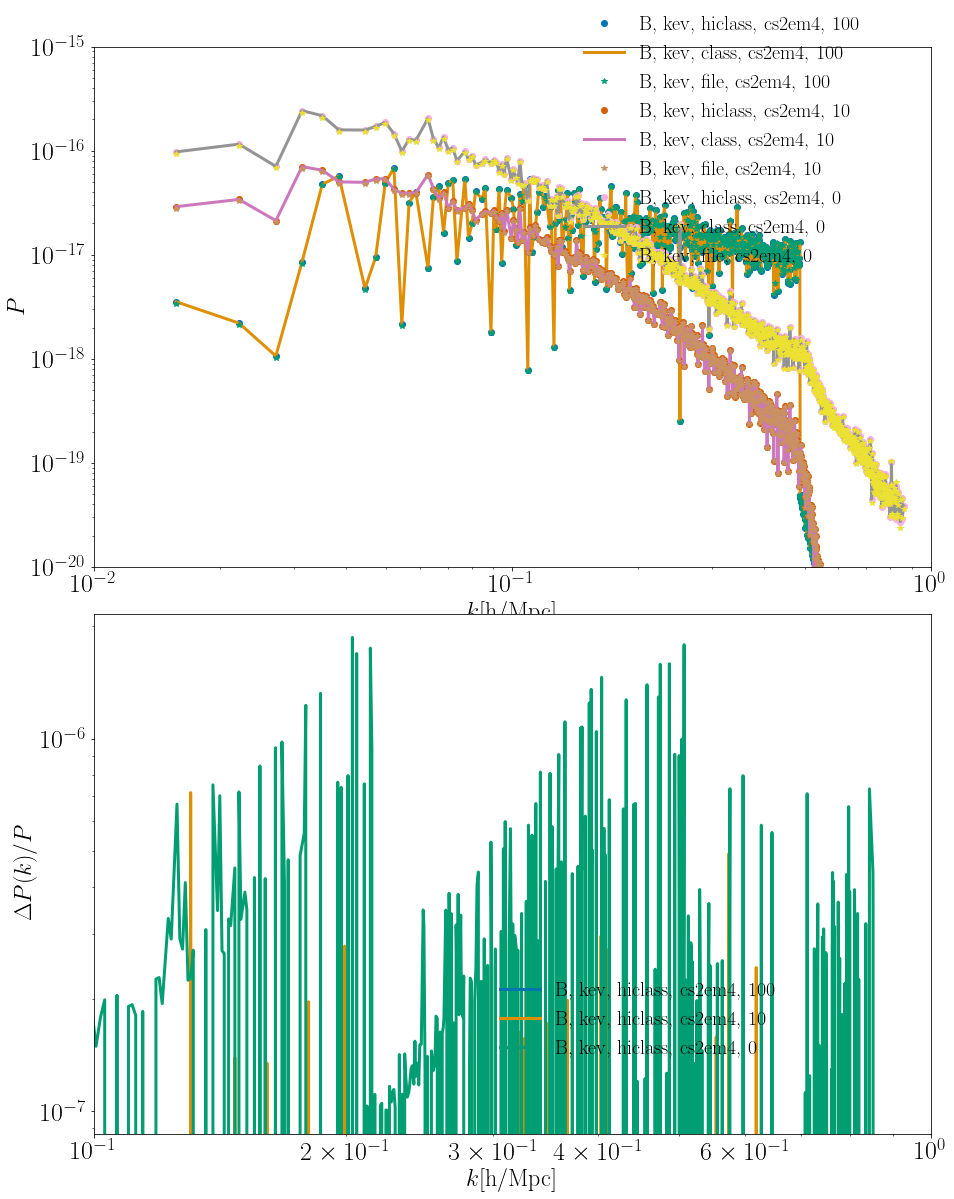

In [38]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)

Normlization=As*(data['class']['tk']['cs2em4']['100'][:,0]/kp)**(ns-1.);

lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0"]:
    l=0
    for speed in ['cs2em4']:
        for kind in ['B']:
#             lc=0
            for types in ['kev_hiclass','kev_class','kev_file']:
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[0].plot(file[:,0],file[:,1],lines[l],color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

# for z in ["100","1","0"]:
#     for speed in ['cs2em4']:        
#         for types in ['tk']:
#             file = data['class'][types][speed][z];
#             k = file[:,0]
#             delta_cdm = file[:,3]
#             power = delta_cdm**2 * (Normlization)
#             axs[0].loglog(k, power,"-",color =Colors[l+1], lw=3,label=correct_label("class"+types+", "+speed+", "+z))
#             l=l+1

axs[0].set_ylabel(r'$P$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-20,1.e-15)
axs[0].set_xlim(1.e-1,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0"]:
    for speed in ['cs2em4']:
        for kind in ['B']:
#             lc=0
            for types in ['kev_hiclass']:
                file_base=data['kev_class'][speed][kind][z]
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[1].plot(file[:,0],np.abs(file[:,1]/file_base[:,1]-1),"-",color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

axs[1].set_ylabel(r'$\Delta P(k)/P$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
# axs[1].set_ylim(1.e-16,10)
axs[1].set_xlim(1.e-1,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.65,0.22],loc="center",frameon=False)


# delta kess

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.


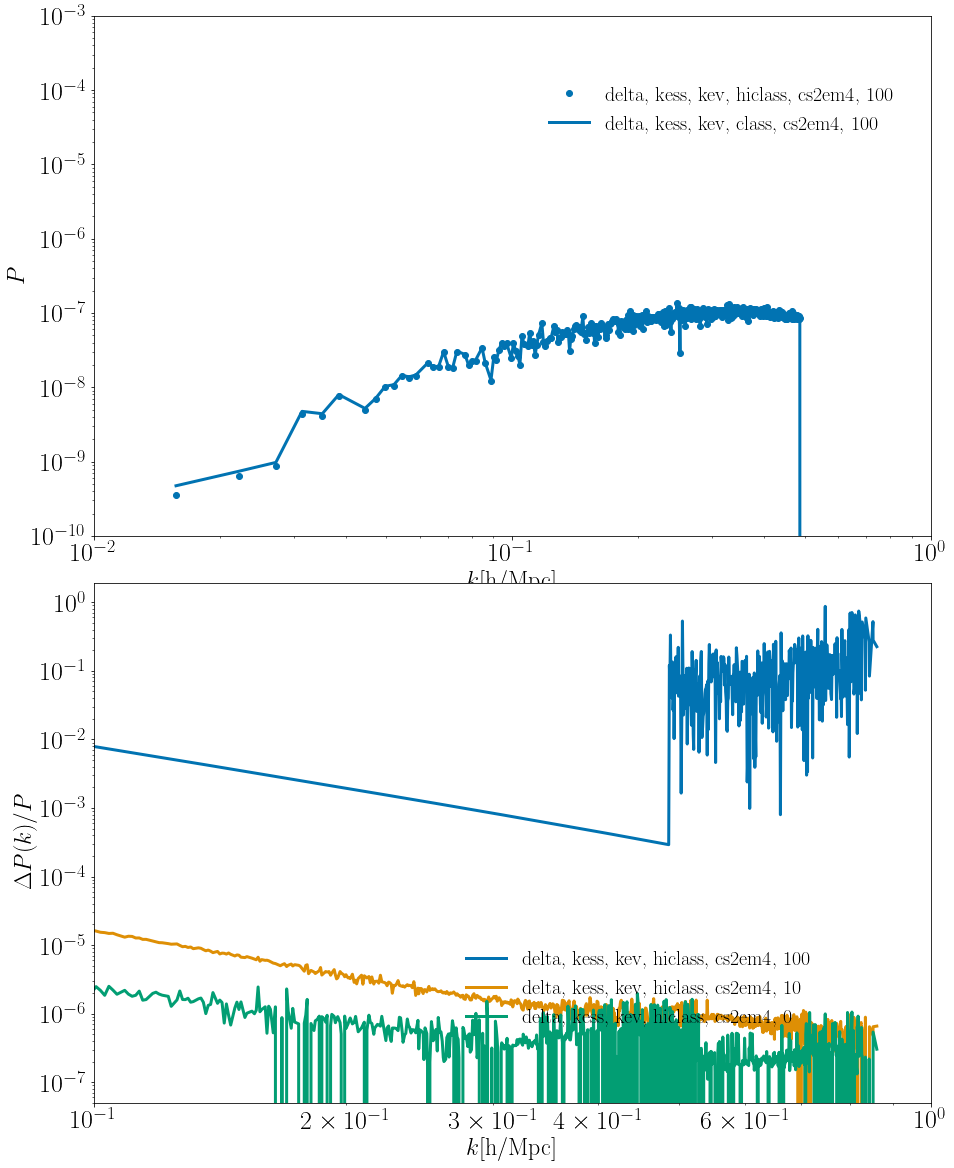

In [40]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)

Normlization=As*(data['class']['tk']['cs2em4']['100'][:,0]/kp)**(ns-1.);

lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100"]:
    l=0
    for speed in ['cs2em4']:
        for kind in ['delta_kess']:
#             lc=0
            for types in ['kev_hiclass','kev_class']:
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[0].loglog(file[:,0],file[:,1],lines[l],color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                
                l=l+1
            lc=lc+1
# for z in ["100","1","0"]:
#     for speed in ['cs2em4']:        
#         for types in ['tk']:
#             file = data['class'][types][speed][z];
#             k = file[:,0]
#             delta_cdm = file[:,3]
#             power = delta_cdm**2 * (Normlization)
#             axs[0].loglog(k, power,"-",color =Colors[l+1], lw=3,label=correct_label("class"+types+", "+speed+", "+z))
#             l=l+1

axs[0].set_ylabel(r'$P$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-10,1.e-3)
axs[0].set_xlim(1.e-1,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0"]:
    for speed in ['cs2em4']:
        for kind in ['delta_kess']:
#             lc=0
            for types in ['kev_hiclass']:
                file_base=data['kev_class'][speed][kind][z]
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[1].plot(file[:,0],np.abs(file[:,1]/file_base[:,1]-1),"-",color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

axs[1].set_ylabel(r'$\Delta P(k)/P$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
# axs[1].set_ylim(1.e-16,10)
axs[1].set_xlim(1.e-1,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.65,0.22],loc="center",frameon=False)


# pi_k power spectrum

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


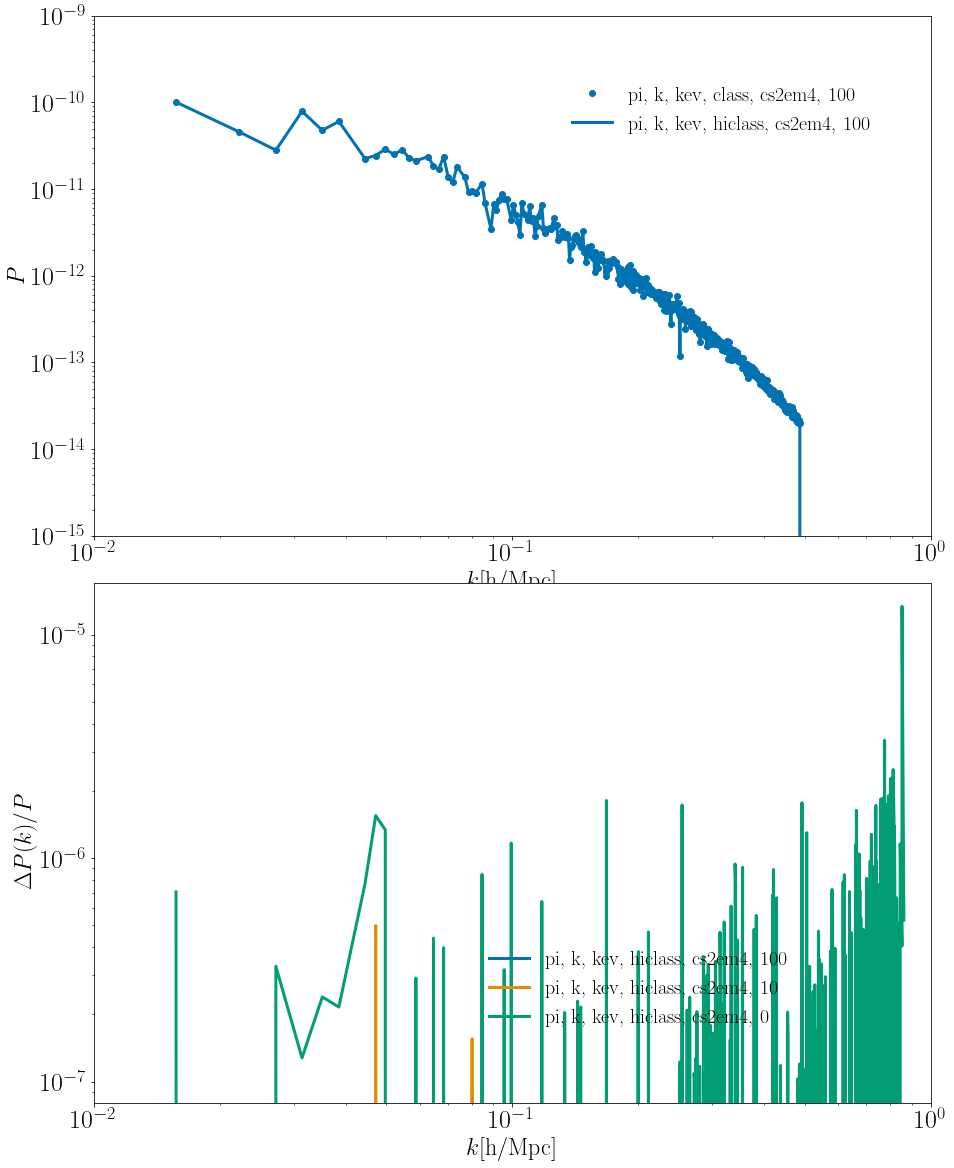

In [41]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)

Normlization=As*(data['class']['tk']['cs2em4']['100'][:,0]/kp)**(ns-1.);

lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100"]:
    l=0
    for speed in ['cs2em4']:
        for kind in ['pi_k']:
#             lc=0
            for types in ['kev_class','kev_hiclass']:
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[0].loglog(file[:,0],file[:,1],lines[l],color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
            lc=lc+1

# for z in ["100","1","0"]:
#     for speed in ['cs2em4']:        
#         for types in ['tk']:
#             file = data['class'][types][speed][z];
#             k = file[:,0]
#             delta_cdm = file[:,3]
#             power = delta_cdm**2 * (Normlization)
#             axs[0].loglog(k, power,"-",color =Colors[l+1], lw=3,label=correct_label("class"+types+", "+speed+", "+z))
#             l=l+1

axs[0].set_ylabel(r'$P$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-15,1.e-9)
axs[0].set_xlim(1.e-1,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0"]:
    for speed in ['cs2em4']:
        for kind in ['pi_k']:
#             lc=0
            for types in ['kev_hiclass']:
                file_base=data['kev_class'][speed][kind][z]
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[1].loglog(file[:,0],np.abs(file[:,1]/file_base[:,1]-1),"-",color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

axs[1].set_ylabel(r'$\Delta P(k)/P$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
# axs[1].set_ylim(1.e-16,10)
axs[1].set_xlim(1.e-2,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.65,0.22],loc="center",frameon=False)


# zeta power

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


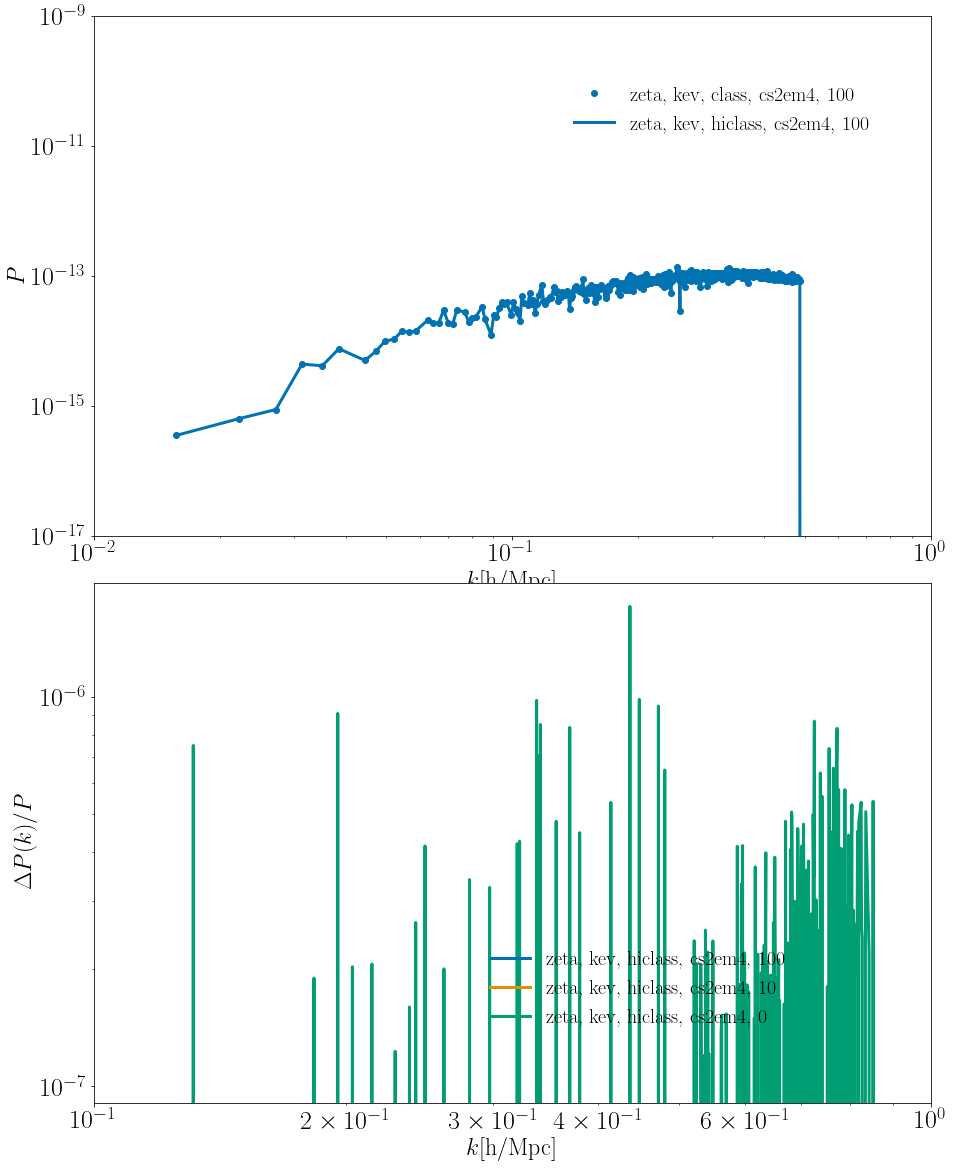

In [43]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)

Normlization=As*(data['class']['tk']['cs2em4']['100'][:,0]/kp)**(ns-1.);

lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100"]:
    l=0
    for speed in ['cs2em4']:
        for kind in ['zeta']:
#             lc=0
            for types in ['kev_class','kev_hiclass']:
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[0].loglog(file[:,0],file[:,1],lines[l],color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
            lc=lc+1

# for z in ["100","1","0"]:
#     for speed in ['cs2em4']:        
#         for types in ['tk']:
#             file = data['class'][types][speed][z];
#             k = file[:,0]
#             delta_cdm = file[:,3]
#             power = delta_cdm**2 * (Normlization)
#             axs[0].loglog(k, power,"-",color =Colors[l+1], lw=3,label=correct_label("class"+types+", "+speed+", "+z))
#             l=l+1

axs[0].set_ylabel(r'$P$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-17,1.e-9)
axs[0].set_xlim(1.e-1,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


lines = ["o","-","*",".-"]
l=0
lc=0
for z in ["100","10","0"]:
    for speed in ['cs2em4']:
        for kind in ['zeta']:
#             lc=0
            for types in ['kev_hiclass']:
                file_base=data['kev_class'][speed][kind][z]
#             for kind in ['phi','delta', 'B', 'pi_k', 'zeta', 'delta_kess']:
                file = data[types][speed][kind][z]
                axs[1].loglog(file[:,0],np.abs(file[:,1]/file_base[:,1]-1),"-",color =Colors[lc], lw=3,label=correct_label(kind+", "+types+", "+speed+", "+z))
                l=l+1
                lc=lc+1

axs[1].set_ylabel(r'$\Delta P(k)/P$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
# axs[1].set_ylim(1.e-16,10)
axs[1].set_xlim(1.e-1,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.65,0.22],loc="center",frameon=False)


## Numerical check

In [157]:
# kind = 'pow_zeta'
# for redshift in redshifts:

# #     k = data['gev'][kind]['z='+str(redshift)] [:,0]
# #     file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
#     # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

#     file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
#     axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kevolution vs gevolution")

#     file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    
# #     print("At z:"+ str(redshifts[i]) + "\n kevolution vs gevolution max of relative error: " +  str(np.max(file_kev-file_gev )) + " \n kevolution_old vs gevolution max of relative error: " + np.max(file_kev_old-file_gev ) + " \n kevolution_old vs kevolution max of relative error: " + np.max(file_kev_old-file_kev ) )
#     max_kev_gev = np.max(np.abs(file_kev-file_gev )/file_gev)
#     max_kev_old_gev = np.max(np.abs(file_kev_old-file_gev )/file_gev)
#     max_kev_old_kev = np.max(np.abs(file_kev_old-file_kev )/file_kev)

#     print("At z:"+ str(redshift) + " \n kevolution_old vs kevolution max of relative error: " + str(max_kev_old_kev)  + " at k=" + str(k[where(np.abs(file_kev_old-file_kev )/file_kev == max_kev_old_kev)]))
    
